# <center> 七 LangGraph 长短期记忆实现机制及检查点的使用

&emsp;&emsp;我们已经探索了使用基础图结构来实现大模型交互，并逐步引入了各种代理架构，以构建能够处理更复杂逻辑的图结构。随着节点和功能的不断增加，构建出来的应用程序也具备了处理更复杂问题的能力。但是，不论是简单还是复杂的图，一个明显的限制是：**之前课程中的所有实现都只能执行单一任务。也就是说，一旦图被编译并根据用户的输入运行以后，它虽然可以按照既定的图流程输出结果，但在下一次交互时，这个图将无法记住之前的对话内容**。我们可以通过以下代码进行测试，观察这一现象：

<div align=center><img src="../pic/lesson07/1.png" width=80%></div>

&emsp;&emsp;下面的代码中实现的是一个最简单、最基础的基于`LangGraph`构建的图：

In [1]:
import getpass
import os

key="sk-kDWtZI52tOWLYiREfzzsD7Z3XEsEH5n6SClKqZ4Lxr5GcM"
base_url="https://chatapi.littlewheat.com/v1"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)

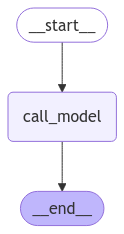

In [4]:
import getpass
import os
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.graph.message import add_messages



# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 定义对话节点
def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}

# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# 编译图
simple_graph = builder.compile()

# 可视化
display(Image(simple_graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;我们来对这个图进行多轮的问答交互，测试其上下文记忆能力。首先进行第一轮提问：

In [5]:
async for chunk in simple_graph.astream(input={"messages": ["你好，我叫西瓜老师"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！很高兴见到你。有什么我可以帮助你的呢？


&emsp;&emsp;接下来进行第二轮提问：

In [6]:
async for chunk in simple_graph.astream(input={"messages": ["你知道我叫什么吗？"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你知道我叫什么吗？
================================== Ai Message ==================================

对不起，我不知道你的名字。我无法获取个人信息。如果你愿意，可以告诉我你的名字。


&emsp;&emsp;第三轮提问继续测试：

In [7]:
async for chunk in simple_graph.astream(input={"messages": ["请问我刚才都问了你什么问题？"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

请问我刚才都问了你什么问题？
================================== Ai Message ==================================

对不起，我没有办法查看或记住先前的对话记录。如果你有任何问题，请随时再问我！


&emsp;&emsp;从上述三轮提问和响应的分析中，我们可以清楚地看到，虽然每轮的问题都是输入到同一个编译后的`graph`实例，但是每次它表现得都像一个"新图"一样，完全不知道自己之前做了什么。所以很显然，**当前的图结构是缺乏上下文记忆能力的**。首先要明确的是：**大模型本身是不具备记忆能力的。**在之前的课程中，我们讨论过为大模型赋予记忆能力的方法，通常是通过维护一个消息列表来保存之前的对话内容，然后在每次新的对话时填充到整体的`Prompt`中，从而实现上下文的持续性。比如下面的代码：

In [8]:
from openai import OpenAI
client = OpenAI(api_key=key,base_url=base_url)

In [9]:
completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "user", "content": "你好，我叫西瓜老师"},
    {"role": "assistant", "content": "你好，西瓜老师，很高兴认识你。"},
    {"role": "user", "content": "你知道我叫什么吗？"}
  ]
)

print(completion.choices[0].message.content)

你刚才告诉我你叫西瓜老师。请问有什么我可以帮忙的吗？


&emsp;&emsp;当我们通过在`Prompt`中填入之前的问答对话，并将其与新一轮的问题一起发送给大模型时，大模型就能够理解并维持对话的上下文。这种方法是我们在多个应用场景中实现大模型记忆功能的经典做法。这里可以有的小伙伴会比较疑惑，在构建图的时候不是通过`State`状态模式中的`add_messages`这个`Reducer`函数维护了一个消息列表吗，看似已经在处理记忆功能，为何不生效？正如下面这样：

In [10]:
async for chunk in simple_graph.astream(input={"messages": ["你好，我叫西瓜老师"]}, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='你好，我叫西瓜老师', additional_kwargs={}, response_metadata={}, id='f1fb0136-eabb-47f4-9059-50fe45454ec5')]}
{'messages': [HumanMessage(content='你好，我叫西瓜老师', additional_kwargs={}, response_metadata={}, id='f1fb0136-eabb-47f4-9059-50fe45454ec5'), AIMessage(content='你好，西瓜老师！很高兴见到你。有什么我可以帮助你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 13, 'total_tokens': 33, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'stop', 'logprobs': None}, id='run-b44ada7e-11f9-41cc-9766-517754d393d3-0', usage_metadata={'input_tokens': 13, 'output_tokens': 20, 'total_tokens': 33, 'input_token_details': {}, 'output_token_details': {}})]}


&emsp;&emsp;如上输出所示，在`Start`节点到`call_model`节点之间，在`Messages`中记录了`HumanMessage(content='你好，我叫西瓜老师', ....）`的有效信息，而在`call_model`到`END`节点之间，在在`Messages`中记录了`HumanMessage(content='你好，我叫西瓜老师', ....），AIMessage(content='你好，西瓜老师！很高兴认识你。有什么我可以帮助你的吗？)....'`的有效信息，这看起来是合理的。但是当我们发起一轮新的问答的时候：

In [11]:
async for chunk in simple_graph.astream(input={"messages": ["请问你知道我叫什么吗？"]}, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='请问你知道我叫什么吗？', additional_kwargs={}, response_metadata={}, id='735fb492-cfdf-4a0e-8dda-22a00571e643')]}
{'messages': [HumanMessage(content='请问你知道我叫什么吗？', additional_kwargs={}, response_metadata={}, id='735fb492-cfdf-4a0e-8dda-22a00571e643'), AIMessage(content='对不起，我不能识别你的名字或个人信息。你可以告诉我或问任何其他问题，我会尽力帮助你。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 15, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9fb440fa-fb03-41d6-80e6-b87a43c451d9-0', usage_metadata={'input_tokens': 15, 'output_tokens': 28, 'total_tokens': 43, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_det

&emsp;&emsp;如果按照能让该图具备上下文记忆能力的话，其维护的`Messages`应该是：
```json
{'messages': [HumanMessage(content='你好，我叫西瓜老师') .....]
    
{'messages': [HumanMessage(content='你好，我叫西瓜老师') , 
              AIMessage(content='你好，西瓜老师！很高兴认识你。有什么我可以帮助你的吗？') .....]

{'messages': [HumanMessage(content='你好，我叫西瓜老师') ,  
              AIMessage(content='你好，西瓜老师！很高兴认识你。有什么我可以帮助你的吗？') , 
              HumanMessage(content='你知道我叫什么吗？')....]
```

&emsp;&emsp;显然在第二轮提问后，`State`状态中的`messages`字段并未如预期那样更新，这就导致了即使是同一个图连续接收到用户的问题，每一个问题对于它而言都是完全新的，没有任何上下文关联。所以，**在`LangGraph`框架中，`State`状态模式的设计本质上是用于在单次运行期间维持和传递整个图节点的消息状态。每次运行完成后，状态会重置到初始状态。以此确保每次运行的独立性，防止了不同运行间的数据干扰。但这也意味着图无法保留跨次运行的上下文信息**。这是`State`状态模式的一个常见误区，大家要特别注意理解。

&emsp;&emsp;那如何做到上下文的记忆功能呢？我们就需要深入了解一下`LangGraph`中的`checkpointer`模块设计。这个模块用于**灵活管理`State`状态中产生的有效信息，能够保存历史数据，并在需要时将这些数据传递回图中，从而赋予整个图结构上下文记忆的能力，以此来保持状态信息的连续性。**

# 1. AI Agent的记忆认知

&emsp;&emsp;**记忆是一种允许个体存储、检索并利用信息以理解过去和规划未来的关键认知功能**。像人类一样，通过学习、经验获得的知识可以在需要的时候从大脑中检索出来。对于`AI Agent`来说，随着其承担越来越复杂、涉及大量用户交互的任务，通过`State`状态的管理，是可以处理从大任务拆分出来的各个子任务间的记录和阶段性成果，这本质上就是一种记忆形式。而如果我们还期望`AI Agent`能在连续的交互中跨对话理解之前的行为，这同样是一种记忆能力的体现。

&emsp;&emsp;总的来说，无论是运行中的状态信息传递还是跨对话间的信息保存，记忆功能都适用于多种场景，并有多种实现方式。**不同的结构框架对`Memory`的实现和定位都会有所不同，但都会将其所实现的记忆功能分为短期记忆和长期记忆两大类，以适应不同的应用需求。**我们**对短期记忆的普遍理解是指那些存储在缓存、内存或程序运行过程中的状态信息**。这类信息通常作为整个大模型或`Agent`的短期记忆，在构建过程中通过数据接口进行临时存储，并在任务完成后直接被清除，就像`LangGraph`的`State`状态机制一样。相对地，**长期记忆通常涉及将重要数据通过特定方式持久化保存在某种存储容器中，任何程序都可以在这里提取到内容，且不受时间的影响**，一般这种常规的实现方法是数据库的本地存储。

&emsp;&emsp;我们正在学习的`LangGraph`框架，其官方的设计思路就如下图所示：

> LangGraph Memory Docs：https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory

<div align=center><img src="../pic/lesson07/a.png" width=80%></div>

&emsp;&emsp;上图来自于`LangGraph`的官方文档。**不同的开发框架会因为其整体架构的设计而对长短期记忆有不同的定位，同时也会根据其底层的开发原理来做不同形式的具体实现**。每个`AI Agent`开发框架都会包含记忆模块，但具体应用的方法一定都是不一样的，也势必会产生特有的专业名词来定义这个过程。正如上图所示，`LangGraph` 框架通过`Checkpointer` 和 `Store`分别作为长短期记忆的管理模块，而其整体对这两类记忆的定位则是：

- **短期记忆：允许代理访问图中较早步骤中获取的信息，并且可以可以随时从与用户的单个对话线程中调用。**
- **长期记忆：使代理能够回忆起之前交互中的信息，例如对话中过去的消息，并且可以在对话线程之间共享，在任何时间、任何线程中调用。**

&emsp;&emsp;因此，无论是想在已有的图中加入短期记忆还是长期记忆，理解它们管理模式的具体实现方法就是我们学习的关键。首先，让我们探讨用于管理短期记忆的`Checkpointer`。

# 2. 短期记忆及Checkpointer（检查点）

&emsp;&emsp;在介绍`LangGraph`中的`Checkpointer`功能之前，我们先利用已学的知识分析一下图在运行时处理中间过程信息的方式。这里我们构建一个简单的图，包括两个节点：`call_model`节点用于加载一个大模型并回答用户输入的问题，而`translate_message`节点则将`call_model`生成的回答翻译成英文。以下是完整的代码实现：

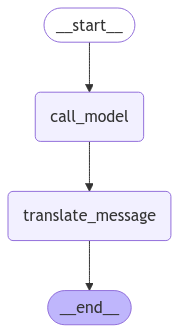

In [12]:
import getpass
import os
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.graph.message import add_messages


llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)

# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 定义大模型交互节点
def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}

# 定义翻译节点
def translate_message(state: State):
    system_prompt = """
    Please translate the received text in any language into English as output
    """
    messages = state['messages'][-1]
    messages = [SystemMessage(content=system_prompt)] + [HumanMessage(content=messages.content)]
    response = llm.invoke(messages)
    return {"messages": response}

# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)
builder.add_node("translate_message", translate_message)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "translate_message")
builder.add_edge("translate_message", END)

# 编译图
simple_short_graph = builder.compile()

# 生成可视化图像结构
display(Image(simple_short_graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;首先我们测试图的运行流程，这里使用异步的流式输出形式，并指定它的输出模式为`values`。代码如下

In [13]:
async for chunk in simple_short_graph.astream(input={"messages": ["你好，我叫西瓜老师"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！很高兴见到你。有什么我可以帮助你的吗？
================================== Ai Message ==================================

Hello, Teacher Watermelon! Nice to meet you. Is there anything I can help you with?


In [14]:
async for chunk in simple_short_graph.astream(input={"messages": ["请问，我叫什么？"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

================================ Human Message =================================

请问，我叫什么？
================================== Ai Message ==================================

抱歉，我无法知道你的名字。
================================== Ai Message ==================================

Sorry, I can't know your name.


&emsp;&emsp;这里确定当前的`graph`实例不具备任何的上下文记忆能力。然后我们进入`Debug`模式去分析其中间过程。代码如下：

In [16]:
async for chunk in simple_short_graph.astream({"messages": ["你好，我叫西瓜老师"]}, stream_mode="debug"):
     #print(chunk)
    print(f"Task id : {chunk['payload']['id']}")
    if chunk["type"] == "task":
        for message in chunk["payload"]["input"]["messages"]:
            print(f"Message id:{message.id}, Message content:{message.content}")

    if chunk["type"] == "task_result":
         print(f"Message id:{chunk['payload']['result'][0][1].id}, Message content:{chunk['payload']['result'][0][1].content}")  # tuple 类型

    print("------------------------------------------------")
    print("------------------------------------------------")

Task id : a3095fc4-8f7d-f3a2-a5b5-12c706a3c09c
Message id:77dea20a-eb48-4cd7-a388-405a5bbbfc6e, Message content:你好，我叫西瓜老师
------------------------------------------------
------------------------------------------------
Task id : a3095fc4-8f7d-f3a2-a5b5-12c706a3c09c
Message id:run-84a5287a-3ad0-453c-b56d-8c9789aba39a-0, Message content:你好，西瓜老师！很高兴见到你。有什么我可以帮助你的吗？
------------------------------------------------
------------------------------------------------
Task id : ac1f681e-8ff2-4f62-bcda-6f467df25d2d
Message id:77dea20a-eb48-4cd7-a388-405a5bbbfc6e, Message content:你好，我叫西瓜老师
Message id:run-84a5287a-3ad0-453c-b56d-8c9789aba39a-0, Message content:你好，西瓜老师！很高兴见到你。有什么我可以帮助你的吗？
------------------------------------------------
------------------------------------------------
Task id : ac1f681e-8ff2-4f62-bcda-6f467df25d2d
Message id:run-647970e0-b95f-411d-ac98-3a18248c7dd5-0, Message content:Hello, Teacher Watermelon! It's nice to meet you. Is there anything I can help you with?
----------

观察到任务阶段和任务生成阶段，两个Task是一样的，针对于每一条Message，都会有唯一的一个ID进行标识。

&emsp;&emsp;再进行一轮问答：我们去验证刚刚得出来的结论

In [17]:
async for chunk in simple_short_graph.astream({"messages": ["你知道我叫什么吗?"]}, stream_mode="debug"):
    # print(chunk)
    print(f"Task id : {chunk['payload']['id']}")
    if chunk["type"] == "task":
        for message in chunk["payload"]["input"]["messages"]:
            print(f"Message id:{message.id}, Message content:{message.content}")

    if chunk["type"] == "task_result":
         print(f"Message id:{chunk['payload']['result'][0][1].id}, Message content:{chunk['payload']['result'][0][1].content}")  # tuple 类型

    print("------------------------------------------------")
    print("------------------------------------------------")

Task id : 44e52f48-bf04-6dd1-f230-1fab0c13e3ba
Message id:375b181c-9171-4d81-94a4-dbac88d386ee, Message content:你知道我叫什么吗?
------------------------------------------------
------------------------------------------------
Task id : 44e52f48-bf04-6dd1-f230-1fab0c13e3ba
Message id:run-7da4b6c0-8b8e-4c18-b71a-134485156c68-0, Message content:对不起，我不知道你的名字。你可以告诉我。
------------------------------------------------
------------------------------------------------
Task id : 66de3d36-35d9-b8b0-3baa-8e01830156c4
Message id:375b181c-9171-4d81-94a4-dbac88d386ee, Message content:你知道我叫什么吗?
Message id:run-7da4b6c0-8b8e-4c18-b71a-134485156c68-0, Message content:对不起，我不知道你的名字。你可以告诉我。
------------------------------------------------
------------------------------------------------
Task id : 66de3d36-35d9-b8b0-3baa-8e01830156c4
Message id:run-0fcb9455-37ff-4e15-8493-f88d5a07b102-0, Message content:I'm sorry, I don't know your name. Can you tell me?
------------------------------------------------
------------

&emsp;&emsp;观察上面两轮对话中我们打印的关键信息。在`State`状态管理的事件流中，每个阶段都会生成一个`task`，并且每个`task`被分为两个阶段：生成（当前事件）和执行结果（`task_result`）。这两个阶段都有一个唯一的且共同的`task id`。此外，每条消息，无论是用户输入的还是大模型生成的回复，都有一个唯一的ID。

&emsp;&emsp;那么，既然每个消息都有不同的`ID`, 如果想让后面的交互过程知道前面都产生了哪些消息，**如果有一种机制可以把消息维护起来（比如使用字典来存储会话，其中每个会话ID映射到一个消息列表），当新一轮的输入进来，我们把指定的消息列表作为初始状态追加到`State`状态中（默认新一轮`State`状态会重新初始化），借助`State`状态可以全局共享的机制，是不是就能实现上下文记忆了呢？** 

```json
sessions = {
    "会话1": [
        {
            "id": "message_1",
            "content": "你好！",
            "timestamp": "2025-10-30T09:00:00"
        },
        {
            "id": "message_2",
            "content": "请问有什么可以帮助您的？",
            "timestamp": "2025-10-30T09:05:00"
        },
        {
            "id": "message_3",
            "content": "感谢，再见！",
            "timestamp": "2025-10-30T09:10:00"
        }
    ],
    "会话2": [
        {
            "id": "message_5",
            "content": "怎么了解更多产品信息？",
            "timestamp": "2025-10-30T10:00:00"
        },
        {
            "id": "message_7",
            "content": "请查看我们的产品目录。",
            "timestamp": "2025-10-30T10:05:00"
        },
        {
            "id": "message_3",
            "content": "感谢，再见！",
            "timestamp": "2025-10-30T09:10:00"
        }
    ]
}

```

&emsp;&emsp;理解到这里，现在我们就可以说：`LangGraph`框架中的`checkpointer`做的就是这样的事。具体来说，**它就是通过一些数据结构来存储`State`状态中产生的信息，并且在每个`task`开始时去读取全局的状态**。主要通过以下四种方式来实现：

- **MemorySaver：** 用于实验性质的记忆检查点。
- **SqliteSaver / AsyncSqliteSaver：** 使用 `SQLite` 数据库 实现的记忆检查点，适合实验性质和本地工作流程。
- **PostgresSaver / AsyncPostgresSaver：** 使用 `Postgres` 数据库实现的高级检查点，适合在生产系统中使用。
- **支持自定义检查点**。

&emsp;&emsp;不同类型的`checkpointer`以不同的形式去管理`State`状态中记录的中间状态信息。但这还不够。为了将一系列产生的消息归属到正确的类别中，就像上面的`会话1`包含一系列的问答，而`会话2`包含另一批系列的回答，`LangGraph`框架引入`Thread`（线程）概念来充当`会话`的角色。每个线程代表一个独特的交互或对话流。而`thread_id`是与特定执行线程关联的唯一标识符各个概念之间的关联如下图所示：

<div align=center><img src="../pic/lesson07/b.png" width=80%></div>

&emsp;&emsp;`checkpointer`是`memory`的一种特定实现，它在执行期间保存图在各个点的状态，使系统能够在中断时从该点恢复。这**与 `LangGraph` 中状态的一般概念不同，后者表示应用程序在任何给定时刻的当前快照。虽然状态是动态的并且随着图形的执行而变化，但`checkpointer`提供了一种存储和检索历史状态的方法**，从而促进更复杂的工作流程和人机交互。

&emsp;&emsp;接下来，我们以 `MemorySaver` 这个实现`checkpointer`的方法为例，帮助大家理解这个过程。

## 2.1 检查点的特定实现类型-MemorySaver

&emsp;&emsp;`LangGraph` 框架有一个内置的持久层，通过`checkpointer`实现。**当使用`checkpointer`编译图时，检查点会在每个超级步骤中保存图状态的`checkpoint`（可以理解每次State更新，checkpoint就打一次快照）。这些`checkpoint`被保存到一个`thread`中，可以在图执行后访问**。如下图所示：

> 超级步骤可以被认为是图节点上的单次迭代(前面我们看到的一个[Task,TaskResult],就是一个超级步骤)。并行运行的节点是同一超级步骤的一部分，而顺序运行的节点则属于单独的超级步骤。在图执行开始时，所有节点都开始处于inactive状态。当节点在其任何传入边缘（或一个“通道”）上接收到新消息（状态）时，该节点将变为active 。然后，活动节点运行其功能并以更新进行响应。在每个超级步骤结束时，没有传入消息的节点通过将自己标记为inactive 。当所有节点inactive并且没有消息在传输时，图执行终止。

<div align=center><img src="../pic/lesson07/c.png" width=100%></div>

&emsp;&emsp;`MemorySaver`是实现上述流程的一种形式，它通过使用 `defaultdict` 将`checkpointer`存储在`memory`中。如下源码所示：

```python
class MemorySaver(
    BaseCheckpointSaver[str], AbstractContextManager, AbstractAsyncContextManager
):
    # thread ID ->  checkpoint NS -> checkpoint ID -> checkpoint mapping
    storage: defaultdict[
        str,
        dict[
            str, dict[str, tuple[tuple[str, bytes], tuple[str, bytes], Optional[str]]]
        ],
    ]
    writes: defaultdict[
        tuple[str, str, str], dict[tuple[str, int], tuple[str, str, tuple[str, bytes]]]
    ]
```

> https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver


&emsp;&emsp;使用的方法非常简单，就是在创建任何 `LangGraph` 图时，通过在编译图时添加`MemorySaver`来将其设置为保留其`State`状态中的数据，即：

```python
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
graph.compile(checkpointer=checkpointer)
```

&emsp;&emsp;我们通过一个图来理解这个中间过程，构建如下图结构。注意：**在编译图的时候，添加`MemorySaver`作为`checkpointer`提供`Memory`功能。**

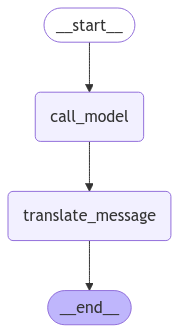

In [18]:
# 导入检查点
from langgraph.checkpoint.memory import MemorySaver

llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)


class State(TypedDict):
    messages: Annotated[list, add_messages]

def call_model(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": response}

def translate_message(state: State):
    system_prompt = """
    Please translate the received text in any language into English as output
    """
    messages = state['messages'][-1]
    messages = [SystemMessage(content=system_prompt)] + [HumanMessage(content=messages.content)]
    response = llm.invoke(messages)
    return {"messages": response}

builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("translate_message", translate_message)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "translate_message")
builder.add_edge("translate_message", END)


memory = MemorySaver()
graph_with_memory = builder.compile(checkpointer=memory)   # 在编译图的时候添加检查点

display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

&emsp;&emsp;当添加了`checkpointer`后，在该图执行的每个超级步骤中会自动创建检查点。即每个节点处理其输入并更新状态后，会当前状态将保存为检查点。但如果像普通图一样，仅传入输入的问题是会报错的，如下所示：

In [19]:
async for chunk in graph_with_memory.astream(input={"messages": ["你好，我叫西瓜老师"]}, stream_mode="values"):
    message = chunk["messages"][-1].pretty_print()

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

&emsp;&emsp;这是因为**当增加了`checkpointer`后，需要`Thread`来作为`checkpointer`保存图中每个检查点的唯一标识，而`Thread`（线程）又是通过`thread_id`来标识某个特定执行线程，所以在使用`checkpointer`调用图时，必须指定`thread_id`，指定的方式是作为配置`configurable`的一部分进行声明。** 正确调用的代码就如下所示：

In [20]:
# 这个 thread_id 可以取任意数值
config = {"configurable": {"thread_id": "1"}}

for chunk in graph_with_memory.stream({"messages": ["你好，我叫西瓜老师"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()


for chunk in graph_with_memory.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！很高兴见到你。请问有什么我可以帮助你的地方吗？
================================== Ai Message ==================================

Hello, Teacher Xigua! It's a pleasure to meet you. Is there anything I can help you with?
================================ Human Message =================================

请问我叫什么？
================================== Ai Message ==================================

你自我介绍时说你叫西瓜老师。不知道我有没有记错？
================================== Ai Message ==================================

When you introduced yourself, you said your name is Teacher Watermelon. I'm not sure if I remembered correctly?


In [21]:
for chunk in graph_with_memory.stream({"messages": ["我刚才都问了你什么问题？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我刚才都问了你什么问题？
================================== Ai Message ==================================

你刚才问了我两个问题。第一个问题是“请问我叫什么？”第二个问题是“我刚才都问了你什么问题？”
================================== Ai Message ==================================

You just asked me two questions. The first question was "What is my name?" The second question was "What questions did I just ask you?"


&emsp;&emsp;现在可以发现与`Agent`的交互中每次它都能记住之前的消息。然后我们再深入细节了解一下，当添加了检查点后，其中间状态的信息会有什么变化。如下代码所示：

In [22]:
config = {"configurable": {"thread_id": "2"}}

for chunk in graph_with_memory.stream({"messages": ["你好,我叫西瓜老师"]}, config, stream_mode="debug"):
     print(chunk)
    # if chunk["type"] == "checkpoint":

    #     print(f"Thread id:{chunk['payload']['config']['configurable']['thread_id']}")
    #     print(f"CheckPoint id :{chunk['payload']['config']['configurable']['checkpoint_id']}")

    #     for message in chunk['payload']['values']['messages']:
    #         print(f"Message id:{message.id}，Message content:{message.content}")
      
    # print(f"Task id : {chunk['payload']['id']}")
    # if chunk["type"] == "task":
    #     for message in chunk["payload"]["input"]["messages"]:
    #         print(f"Message id:{message.id}, Message content:{message.content}")

    # if chunk["type"] == "task_result":
    #      print(f"Message id:{chunk['payload']['result'][0][1].id}, Message content:{chunk['payload']['result'][0][1].content}")  # tuple 类型

    # print("------------------------------------------------")
    # print("------------------------------------------------")

{'type': 'checkpoint', 'timestamp': '2025-01-04T03:08:49.778059+00:00', 'step': -1, 'payload': {'config': {'tags': [], 'metadata': ChainMap({'thread_id': '2'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '2', 'checkpoint_id': '1efca493-84d3-60a1-bfff-c5514f3d5686'}}, 'parent_config': None, 'values': {'messages': []}, 'metadata': {'source': 'input', 'writes': {'__start__': {'messages': ['你好,我叫西瓜老师']}}, 'thread_id': '2', 'step': -1, 'parents': {}}, 'next': ['__start__'], 'tasks': [{'id': '2426e2d1-9344-3655-2992-c1e5e1d79230', 'name': '__start__', 'interrupts': (), 'state': None}]}}
{'type': 'checkpoint', 'timestamp': '2025-01-04T03:08:49.793898+00:00', 'step': 0, 'payload': {'config': {'tags': [], 'metadata': ChainMap({'thread_id': '2'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '2', 'checkpoint_id': '1efca493-84f9-6c30-8000-1f3fa4688cc6'}}, 'parent_config': {'tags': [], 'metadata': Cha

&emsp;&emsp;每个`super-step`后，都会生成一个`checkpointer`存储中间信息，而一次交互中，只会存在一个`thread_id`，也就是我们在`config = {"configurable": {"thread_id": "2"}}`中自定义的线程ID，当我们再次使用相同的`thread_id`进行问答时，图在执行前后自动加载该`thread_id`之前存储的所有的信息，添加到新一轮问答的初始状态中，比如下面的代码，我们仍然使用`{"thread_id": "2"}`再次进行交互；

In [23]:
config = {"configurable": {"thread_id": "2"}}

for chunk in graph_with_memory.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="debug"):
    if chunk["type"] == "checkpoint":
        # print(chunk)
        print(f"Thread id:{chunk['payload']['config']['configurable']['thread_id']}")
        print(f"CheckPoint id :{chunk['payload']['config']['configurable']['checkpoint_id']}")

        for message in chunk['payload']['values']['messages']:
            print(f"Message id:{message.id}，Message content:{message.content}")
      
    # print(f"Task id : {chunk['payload']['id']}")
    # if chunk["type"] == "task":
    #     for message in chunk["payload"]["input"]["messages"]:
    #         print(f"Message id:{message.id}, Message content:{message.content}")

    # if chunk["type"] == "task_result":
    #      print(f"Message id:{chunk['payload']['result'][0][1].id}, Message content:{chunk['payload']['result'][0][1].content}")  # tuple 类型

    print("------------------------------------------------")
    print("------------------------------------------------")

Thread id:2
CheckPoint id :1efca497-a33e-6212-8003-3e95ac51217c
Message id:7cfa2739-6253-4058-ad18-aa9cea6e62e4，Message content:你好,我叫西瓜老师
Message id:run-772d6a6b-abb2-498b-a351-c6cfd39c66f7-0，Message content:你好，西瓜老师！很高兴认识你。有什么我可以帮忙的吗？
Message id:run-9c33dc9a-8d46-4571-93e5-6fbaca8aed8f-0，Message content:Hello, Teacher Watermelon! It's nice to meet you. Is there anything I can help you with?
------------------------------------------------
------------------------------------------------
Thread id:2
CheckPoint id :1efca497-a34a-67c5-8004-92304f9cda01
Message id:7cfa2739-6253-4058-ad18-aa9cea6e62e4，Message content:你好,我叫西瓜老师
Message id:run-772d6a6b-abb2-498b-a351-c6cfd39c66f7-0，Message content:你好，西瓜老师！很高兴认识你。有什么我可以帮忙的吗？
Message id:run-9c33dc9a-8d46-4571-93e5-6fbaca8aed8f-0，Message content:Hello, Teacher Watermelon! It's nice to meet you. Is there anything I can help you with?
Message id:64415e95-a694-4320-a960-0b1c0a65a995，Message content:请问我叫什么？
------------------------------------------

&emsp;&emsp;**由此可以印证检查点的机制是：当调用图或完成一个步骤时，其记忆会更新，而如果线程相同，则会在每个步骤开始时读取全部的状态。**如果我们把`thread_id`换成其他的，则会开启全新的一个线程进行对话，比如：

In [24]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_with_memory.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="debug"):
    if chunk["type"] == "checkpoint":
        # print(chunk)
        print(f"Thread id:{chunk['payload']['config']['configurable']['thread_id']}")
        print(f"CheckPoint id :{chunk['payload']['config']['configurable']['checkpoint_id']}")

        for message in chunk['payload']['values']['messages']:
            print(f"Message id:{message.id}，Message content:{message.content}")

Thread id:3
CheckPoint id :1efca49a-e629-61ff-bfff-9be780ea943d
Thread id:3
CheckPoint id :1efca49a-e632-6da1-8000-c3d7a2a1b57f
Message id:0845ca1b-8753-4ebe-aa49-d12dce41d8de，Message content:请问我叫什么？
Thread id:3
CheckPoint id :1efca49a-ef3e-6de9-8001-3650076583fd
Message id:0845ca1b-8753-4ebe-aa49-d12dce41d8de，Message content:请问我叫什么？
Message id:run-bb835975-1196-42af-92c0-cb9dab41993b-0，Message content:抱歉，我无法知道你的名字。
Thread id:3
CheckPoint id :1efca49a-fecb-6709-8002-670f1987258c
Message id:0845ca1b-8753-4ebe-aa49-d12dce41d8de，Message content:请问我叫什么？
Message id:run-bb835975-1196-42af-92c0-cb9dab41993b-0，Message content:抱歉，我无法知道你的名字。
Message id:run-f5eec8ff-acc3-43f9-8787-43c7e356dd19-0，Message content:Sorry, I can't know your name.


&emsp;&emsp;因为`thread_id`变成了3，所以它是完全不具备`thread_id == 2`这个线程中的任何信息的，但我们可以恢复以前的线程并继续进行对话，即：

In [25]:
config = {"configurable": {"thread_id": "2"}}

for chunk in graph_with_memory.stream({"messages": ["你还知道我叫什么吗？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你还知道我叫什么吗？
================================== Ai Message ==================================

除了你之前提到的“西瓜老师”之外，我没有其他关于你名字的信息。如果有需要帮助的地方，请随时告诉我！
================================== Ai Message ==================================

Apart from the "Teacher Watermelon" you mentioned before, I don't have any other information about your name. If there's anything you need help with, please feel free to let me know!


&emsp;&emsp;**短期记忆可让应用程序记住单个线程或对话中先前的交互，并且可以随时找到某个对话线程中继续之前的问答。**这种情况其实就是我们在使用`Web`端应用程序的时候，可以切回到历史的聊天框继续问答的场景。`LangGraph` 将短期记忆作为代理状态的一部分进行管理，并通过线程范围的检查点进行持久化。此状态通常可以包括对话历史记录以及其他状态数据，例如上传的文件、检索的文档或生成的工件。通过将这些存储在图的状态中，程序可以访问给定对话的完整上下文，同时保持不同线程之间的分离。这就是其现实应用价值的体现。

&emsp;&emsp;那么接下来要考虑的是： 既然所实际进行存储的是 `Checkpointer`， 那么`Checkpointer`如何去做持久化的存储呢？正如我们上面使用的 `MemorySaver`， 虽然在当前的代码运行环境下可以去指定线程ID，获取到具体的历史信息，但是，一旦我们重启代码环境，则所有的数据都将被抹除。那么一种持久化的方法就是把每个`checkpointer`存储到本地的数据库中。

## 2.2 检查点的特定实现类型-SqliteSaver

&emsp;&emsp;`SqliteSaver`是`checkponiter`的第二种实现形式，不同于`MemorySaver`仅通过字典的形式将状态信息存储在当前的运行环境下，`SqliteSaver`做的是持久化存储，这个方法会把`checkponiter`实际的存储在本地的`SQLite` 数据库中，同时提供了异步环境下的实现`AsyncSqliteSaver`，适用于轻量级的应用落地场景。

> https://langchain-ai.github.io/langgraph/reference/checkpoints/?h=memory+saver#langgraph.checkpoint.sqlite.SqliteSaver

&emsp;&emsp;`SqliteSaver`源码定义如下：
```python
class SqliteSaver(BaseCheckpointSaver[str]):
    """A checkpoint saver that stores checkpoints in a SQLite database.

    Note:
        This class is meant for lightweight, synchronous use cases
        (demos and small projects) and does not
        scale to multiple threads.
        For a similar sqlite saver with `async` support,
        consider using [AsyncSqliteSaver][langgraph.checkpoint.sqlite.aio.AsyncSqliteSaver].

    Args:
        conn (sqlite3.Connection): The SQLite database connection.
        serde (Optional[SerializerProtocol]): The serializer to use for serializing and deserializing checkpoints. Defaults to JsonPlusSerializerCompat.
```

&emsp;&emsp;`SqliteSaver`有两种存储形式，一种是类似于`MemorySaver`将`checkpointer`存储在内存中，另外一种是存储在`sqlite`数据库中。首先来看第一种：

&emsp;&emsp;内存存储（in-Memory Storage）是指存储在计算机主存储器 (RAM) 中的数据，这种类型的存储允许非常快速地访问和检索数据，因为它不涉及磁盘 I/O 操作。这个过程是将`checkpointer`最初保存到内存中，在需要时从内存中进行检索。内部完整的实现思路如下：

- **Step 1. 安装依赖库**

&emsp;&emsp;需要单独安装`langgraph-checkpoint-sqlite`库。

In [32]:
! pip show langgraph-checkpoint-sqlite

Name: langgraph-checkpoint-sqlite
Version: 2.0.1
Summary: Library with a SQLite implementation of LangGraph checkpoint saver.
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /root/miniconda3/lib/python3.12/site-packages
Requires: aiosqlite, langgraph-checkpoint
Required-by: 


In [31]:
! pip install langgraph-checkpoint-sqlite

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


- **Step 2. 定义内存的存储形式**

&emsp;&emsp;通过`:memory:`方法指定在内存中存储`checkpointer`。代码如下：

In [26]:
from langgraph.checkpoint.sqlite import SqliteSaver

# 创建一个内存中的检查点
memory = SqliteSaver.from_conn_string(":memory:")

- **Step 3. 构建checkpointer**

&emsp;&emsp;这里为了演示`SqliteSaver`的执行原理，我们手动构建一个测试的`checkpointer`，其默认实现的是从`State`中进行提取。

In [27]:
checkpoint_data = {
    "thread_id": "西瓜老师123",  
    "thread_ts": "2025-10-30T07:23:38.656547+00:00", 
    "checkpoint": {
        "id": "1ef968fe-1eb4-6049-bfff", 
    },
    "metadata": {"timestamp": "2025-10-30T07:23:38.656547+00:00"}
}

- **Step 3. 存储checkpointer**

&emsp;&emsp;在源码中，`from_conn_string`方法使用了`Python`的`contextmanager`装饰器，所以它是一个生成器函数。这个方法创建的实例必须在`with`语句中使用。即我们需要修改其构建的方式，并通过`put`方法进行`checkpointer`配置的写入，代码如下：

In [28]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    # 保存检查点，包括时间戳
    saved_config = memory.put(
        config={"configurable": {"thread_id": checkpoint_data["thread_id"], "thread_ts": checkpoint_data["thread_ts"], "checkpoint_ns": ""}},
        checkpoint=checkpoint_data["checkpoint"],
        metadata=checkpoint_data["metadata"],
        new_versions= {"writes": {"key": "value"}}
    )

In [29]:
print(saved_config)

{'configurable': {'thread_id': '西瓜老师123', 'checkpoint_ns': '', 'checkpoint_id': '1ef968fe-1eb4-6049-bfff'}}


&emsp;&emsp;除此之外，还可以通过`list`方法查看到`thread_id`下所有的检查点信息，代码如下：

In [30]:
with SqliteSaver.from_conn_string(":memory:") as memory:
    # 保存检查点，包括时间戳
    saved_config = memory.put(
        config={"configurable": {"thread_id": checkpoint_data["thread_id"], "thread_ts": checkpoint_data["thread_ts"], "checkpoint_ns": ""}},
        checkpoint=checkpoint_data["checkpoint"],
        metadata=checkpoint_data["metadata"],
        new_versions= {"writes": {"key": "value"}}
    )

    # 检索检查点的数据
    config = {"configurable": {"thread_id": checkpoint_data["thread_id"]}}
    
    # 获取给定 thread_id 的所有检查点
    checkpoints = list(memory.list(config))  
    for checkpoint in checkpoints:
        print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': '西瓜老师123', 'checkpoint_ns': '', 'checkpoint_id': '1ef968fe-1eb4-6049-bfff'}}, checkpoint={'id': '1ef968fe-1eb4-6049-bfff'}, metadata={'timestamp': '2025-10-30T07:23:38.656547+00:00'}, parent_config=None, pending_writes=[])


&emsp;&emsp;内部原理如下图所示：

<div align=center><img src="../pic/lesson07/d.png" width=80%></div>

&emsp;&emsp;除此之外，`SQLiteSaver`还支持持久化存储。这种方式是指存储在非易失性介质上的数据，例如硬盘驱动器、SSD 或云存储，即使应用程序停止或系统断电，这种类型的存储也会保留数据。使用的方式也非常简单，只需要把`from_conn_string`中的`:memory:`更换为指向为本地的`sqlite.db`的文件即可，这允许数据持久保存，便于长期存取。代码如下：

In [31]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver 

with SqliteSaver.from_conn_string("checkpoints20251101.sqlite") as memory:
    # 保存检查点，包括时间戳
    saved_config = memory.put(
        config={"configurable": {"thread_id": checkpoint_data["thread_id"], "thread_ts": checkpoint_data["thread_ts"], "checkpoint_ns": ""}},
        checkpoint=checkpoint_data["checkpoint"],
        metadata=checkpoint_data["metadata"],
        new_versions= {"writes": {"key": "value"}}
    )

    # 检索检查点的数据
    config = {"configurable": {"thread_id": checkpoint_data["thread_id"]}}
    
    # 获取给定 thread_id 的所有检查点
    checkpoints = list(memory.list(config))  
    for checkpoint in checkpoints:
        print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': '西瓜老师123', 'checkpoint_ns': '', 'checkpoint_id': '1ef968fe-1eb4-6049-bfff'}}, checkpoint={'id': '1ef968fe-1eb4-6049-bfff'}, metadata={'timestamp': '2025-10-30T07:23:38.656547+00:00'}, parent_config=None, pending_writes=[])


&emsp;&emsp;可以使用标准的 `SQL` 语法直接与数据库进行交互。

In [32]:
# 建立数据库连接
conn = sqlite3.connect("checkpoints20251101.sqlite")

# 创建一个游标对象来执行你的SQL查询
cursor = conn.cursor()

# 查询数据库中所有表的名称
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# 获取查询结果
tables = cursor.fetchall()

In [33]:
# 打印所有表名
for table in tables:
    print(table)

('checkpoints',)
('writes',)


In [34]:
# 从检查点表中检索所有数据
cursor.execute(f"SELECT * FROM checkpoints;")
all_data = cursor.fetchall()

# 打印检查点表中的所有数据
print("Data in the 'checkpoints' table:")
for row in all_data:
    print(row)

Data in the 'checkpoints' table:
('西瓜老师123', '', '1ef968fe-1eb4-6049-bfff', None, 'msgpack', b'\x81\xa2id\xb71ef968fe-1eb4-6049-bfff', b'{"timestamp": "2025-10-30T07:23:38.656547+00:00"}')


## 2.3 通过检查点给图增加持久性记忆

&emsp;&emsp;到目前为止，我们已经探索了`memory`、`checkpointer`、`state`和`thead`的概念，以及如何在内存中存储类似状态的对象。现在我们来看一下如何将不同形式的`memory`集成到`ReAct`代理流程中。

&emsp;&emsp;之前我们课程里面介绍的`LangGraph`预构建组件`ReAct`，通过`create_react_agent`是内部已经实现了图的编译过程，如果想加入`memory`，则只需要在执行`create_react_agent`方法时，新增一个`checkpointer`参数来接收，如下代码所示：

In [35]:
from langchain_core.tools import tool
from typing import Union, Optional
from pydantic import BaseModel, Field
import requests
import json

class WeatherLoc(BaseModel):
    location: str = Field(description="The location name of the city")

@tool(args_schema=WeatherLoc)
def get_weather(location):
    """
    Function to query current weather.
    :param loc: Required parameter, of type string, representing the specific city name for the weather query. \
    Note that for cities in China, the corresponding English city name should be used. For example, to query the weather for Beijing, \
    the loc parameter should be input as 'Beijing'.
    :return: The result of the OpenWeather API query for current weather, with the specific URL request address being: https://api.openweathermap.org/data/2.5/weather. \
    The return type is a JSON-formatted object after parsing, represented as a string, containing all important weather information.
    """
    # Step 1.构建请求
    url = "https://api.openweathermap.org/data/2.5/weather"

    # Step 2.设置查询参数
    params = {
        "q": location,               
        "appid": "5c939a7cc59eb8696f4cd77bf75c5a9a",    # 输入API key
        "units": "metric",            # 使用摄氏度而不是华氏度
        "lang":"zh_cn"                # 输出语言为简体中文
    }

    # Step 3.发送GET请求
    response = requests.get(url, params=params)
    
    # Step 4.解析响应
    data = response.json()
    return json.dumps(data)

In [36]:
get_weather("Beijing")

/tmp/ipykernel_1325/880929365.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_weather("Beijing")


'{"coord": {"lon": 116.3972, "lat": 39.9075}, "weather": [{"id": 802, "main": "Clouds", "description": "\\u591a\\u4e91", "icon": "03d"}], "base": "stations", "main": {"temp": 1.31, "feels_like": 1.31, "temp_min": 1.31, "temp_max": 1.31, "pressure": 1025, "humidity": 16, "sea_level": 1025, "grnd_level": 1020}, "visibility": 10000, "wind": {"speed": 0.54, "deg": 292, "gust": 1.24}, "clouds": {"all": 30}, "dt": 1735961254, "sys": {"country": "CN", "sunrise": 1735947368, "sunset": 1735981320}, "timezone": 28800, "id": 1816670, "name": "Beijing", "cod": 200}'

In [37]:
tools = [get_weather]

In [38]:
llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)

&emsp;&emsp;创建`ReAct`代理的时候添加`memory`，代码如下：

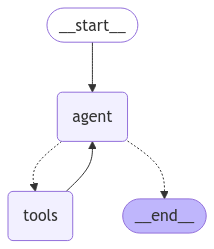

================================ Human Message =================================

你好，我叫西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！有什么我可以帮助你的吗？
================================ Human Message =================================

请问我叫什么？
================================== Ai Message ==================================

你告诉我你叫“西瓜老师”。


In [39]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import create_react_agent

with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    graph = create_react_agent(llm, tools=tools, checkpointer=checkpointer)
    display(Image(graph.get_graph().draw_mermaid_png()))
    
    config = {"configurable": {"thread_id": "11"}}

    for chunk in graph.stream({"messages": ["你好，我叫西瓜老师"]}, config, stream_mode="values"):
        chunk["messages"][-1].pretty_print()
     
    for chunk in graph.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="values"):
        chunk["messages"][-1].pretty_print()

&emsp;&emsp;但这种定义方法是不能跨单元传播的，比如我们在一个新的`cell`中再次对上面创建的图进行问答:

In [40]:
for chunk in graph.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

ProgrammingError: Cannot operate on a closed database.

&emsp;&emsp;出现报错的原因是因为脱离了上下文的环境。每次使用 `SqliteSaver.from_conn_string(":memory:")` 时，都会创建一个新的内存数据库实例，因此无法保持之前会话的状态。内存数据库（`:memory:`）是临时的，只存在于该数据库连接的生命周期内，一旦连接关闭，数据库就会消失。所以一种比较合适的写法是使用 `contextlib.ExitStack` 来作为管理和组织多个上下文管理器，这个方法可以让我们在一个统一的上下文管理堆栈中注册多个上下文管理器，并确保它们按正确的顺序（即最后进入的首先退出）被关闭。所以代码如下：

In [41]:
from contextlib import ExitStack

stack = ExitStack()
checkpointer = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

&emsp;&emsp;上述代码实现的机制是：
1. **创建 `ExitStack` 实例：** `stack = ExitStack()` 创建了一个可以管理多个上下文管理器的堆栈。
2. **注册上下文管理器：** `checkpointer = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))` 这一行将 `SqliteSaver.from_conn_string(":memory:")` 注册到了 `stack` 中。`SqliteSaver.from_conn_string` 返回的上下文管理器对象会被 `ExitStack` 管理，这意味着只有退出 `stack` 的上下文（即调用 `stack.close()`），与之相关的 `SqliteSaver` 才会自动关闭。

In [42]:
graph = create_react_agent(llm, tools=tools, checkpointer=checkpointer)

In [43]:
config = {"configurable": {"thread_id": "111"}}

for chunk in graph.stream({"messages": ["你好，我叫西瓜老师"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
 
for chunk in graph.stream({"messages": ["请问我叫什么？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我叫西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！很高兴见到您。请问有什么我可以帮助您的？
================================ Human Message =================================

请问我叫什么？
================================== Ai Message ==================================

您刚才介绍自己叫西瓜老师。


In [47]:
config = {"configurable": {"thread_id": "22"}}

for chunk in graph.stream({"messages": ["帮我查一下北京的天气"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

帮我查一下北京的天气
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_JdgOx868y1RNmAoz3j4eNXYU)
 Call ID: call_JdgOx868y1RNmAoz3j4eNXYU
  Args:
    location: Beijing
================================= Tool Message =================================
Name: get_weather

{"coord": {"lon": 116.3972, "lat": 39.9075}, "weather": [{"id": 802, "main": "Clouds", "description": "\u591a\u4e91", "icon": "03d"}], "base": "stations", "main": {"temp": 1.31, "feels_like": 1.31, "temp_min": 1.31, "temp_max": 1.31, "pressure": 1025, "humidity": 16, "sea_level": 1025, "grnd_level": 1020}, "visibility": 10000, "wind": {"speed": 0.54, "deg": 292, "gust": 1.24}, "clouds": {"all": 30}, "dt": 1735961254, "sys": {"country": "CN", "sunrise": 1735947368, "sunset": 1735981320}, "timezone": 28800, "id": 1816670, "name": "Beijing", "cod": 200}
================================== Ai Mes

In [48]:
config = {"configurable": {"thread_id": "22"}}

for chunk in graph.stream({"messages": ["请问我刚才问了什么问题？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

请问我刚才问了什么问题？
================================== Ai Message ==================================

你刚才问的问题是关于北京的天气情况。


In [49]:
stack.close()

&emsp;&emsp;这是一个更灵活的方法，适用于同步的环境，其中代码可以跨单元传播，并且仍然可以使用上下文信息。异步版本也是类似的实现思路：

In [55]:
import asyncio
from contextlib import AsyncExitStack
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

stack = AsyncExitStack()
memory = await stack.enter_async_context(AsyncSqliteSaver.from_conn_string(":memory:"))

graph = create_react_agent(llm, tools=tools, checkpointer=memory)

config = {"configurable": {"thread_id": "44"}}

async for chunk in graph.astream({"messages": ["帮我查一下北京的天气"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

帮我查一下北京的天气
================================== Ai Message ==================================
Tool Calls:
  get_weather (call-4Dbk17Li73VeaWbc1xLVPVNOyXO8)
 Call ID: call-4Dbk17Li73VeaWbc1xLVPVNOyXO8
  Args:
    location: Beijing
================================= Tool Message =================================
Name: get_weather

{"coord": {"lon": 116.3972, "lat": 39.9075}, "weather": [{"id": 802, "main": "Clouds", "description": "\u591a\u4e91", "icon": "03d"}], "base": "stations", "main": {"temp": 0.94, "feels_like": 0.94, "temp_min": 0.94, "temp_max": 0.94, "pressure": 1024, "humidity": 16, "sea_level": 1024, "grnd_level": 1018}, "visibility": 10000, "wind": {"speed": 0.72, "deg": 225, "gust": 1.34}, "clouds": {"all": 40}, "dt": 1735961616, "sys": {"type": 1, "id": 9609, "country": "CN", "sunrise": 1735947368, "sunset": 1735981320}, "timezone": 28800, "id": 1816670, "name": "Beijing", "cod": 200}
==========

In [56]:
async for chunk in graph.astream({"messages": ["我刚才问了你什么问题"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我刚才问了你什么问题
================================== Ai Message ==================================

你刚才问我北京的天气情况。


&emsp;&emsp;自然，也可以去处理图的事件流，比如：

In [57]:
async for event in graph.astream_events({"messages": ["请你非常详细的介绍一下你自己"]}, config, version="v2"):
        kind = event["event"]
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
                print(content, end="|")

我是|一个|由|先进|的|人工|智能|技术|驱|动|的|语言|模型|助手|，|专|门|设计|来|帮助|用户|处理|各种|请求|和|问题|。|以下|是|一些|关于|我的|详细|信息|：

|1|.| **|技术|基础|**|：
|  | -| 我|是|基|于|Open|AI|的|GPT|（|Gener|ative| Pre|-trained| Transformer|）|技术|构|建|的|。
|  | -| 我|能够|理解|和|生成|自然|语言|，这|使|我|能够|以|对|话|的|形式|与|用户|互动|。

|2|.| **|功能|范围|**|：
|  | -| 我|可以|帮助|回答|各种|广|泛|的话|题|，包括|但|不限|于|科学|、|历史|、|地|理|、|技术|、|文化|、|娱乐|和|生活|常|识|。
|  | -| 我|也|可以|提供|当前|天气|信息|、|翻|译|文本|、|解释|概|念|、|编|写|文本|、|提供|建议|等|。

|3|.| **|数据|基础|**|：
|  | -| 我的|知识|基础|是|由|大量|文本|数据|训练|而|来的|，|覆盖|了|互联网|的|广|泛|内容|。
|  | -| 我的|知识|更新|至|202|3|年|10|月|，因此|在|此|日期|后的|事件|或|变|更|可能|不|在|我的|知识|范围|内|。

|4|.| **|交流|能力|**|：
|  | -| 我|能够|理解|多|种|语言|，并|可以|进行|多|语言|交流|。
|  | -| 我|旨|在|提供|用户|友|好的|互动|体验|，通过|自然|的|语言|处理|来|回应|问题|。

|5|.| **|局|限|性|**|：
|  | -| 尽|管|我|经过|大量|数据|训练|，但|我|无法|访问|实时|互联网|，也|不能|即时|更新|新闻|或|信息|。
|  | -| 有|时候|我|可能|无法|完全|理解|复杂|的|或|模|糊|的问题|，因此|需要|清|晰|或|简|化|的问题|描述|。

|6|.| **|隐|私|与|安全|**|：
|  | -| 我|不|具|备|存|储|个人|信息|的|能力|，|所有|交|互|都是|一次|性的|，不|会|被|记录|。
|  | -| 用户|的|隐|私|对于|我|来说|是|最高|优|先|级|，我|不|建议|或|鼓|励|分享|个人|敏|感|信

In [58]:
await stack.aclose()

&emsp;&emsp;对于`SqliteSaver`的使用也完全是一样的，大家可以自行进行尝试。

&emsp;&emsp;总的来说，`LangGraph` 框架中的`Memory`通过状态管理与检查点与 `thread_id` 进行绑定，从而隔离不同线程的记忆和状态，防止并发交互之间的干扰，保证每个线程独立运行。总体而言，`thread_id` 是 `LangGraph` 中组织和管理记忆的关键机制，可实现有效的状态跟踪和交互连续性。但是，**通过`thread_id`不能实现的是：跨线程的交互。**我们虽然可以通过`thread_id`去中断或者恢复某个对话，但是让不同线程间共享各自的消息，在`checkpointer`的实现机制下并不能做到，所以有了`LangGraph`的长期记忆的实现模块。

# 3.长期记忆和Store（仓库）

&emsp;&emsp;仅使用`checkpointer`，我们无法做到跨线程共享信息。这激发了对`Store`的需求。`LangGraph`通过`BaseStore`接口提供内置文档存储。与通过线程 ID 保存状态的`checkpointer`不同，存储使用自定义命名空间来组织数据。常见用例包括存储用户配置文件、构建知识库以及管理所有线程的全局首选项。具体的**实现形式是：`LangGraph` 将长期记忆作为 `JSON` 文档存储在`Store`中，每个`memory`都组织在自定义`namespace`（类似于文件夹）和不同的`key` （例如文件名）下。命名空间通常包含用户或组织 ID 或其他标签，以便更轻松地组织信息。这种结构可以实现存储器的分层组织。然后通过内容过滤器支持跨命名空间搜索。**

&emsp;&emsp;**整体而言，`LangGraph` 中的长期记忆允许系统保留不同对话或会话中的信息。与线程范围的短期记忆不同，长期记忆保存在自定义“命名空间”中。**

<div align=center><img src="../pic/lesson07/e.png" width=70%></div>

> `Store`的实现源码：https://langchain-ai.github.io/langgraph/reference/store/

&emsp;&emsp;具体的实现方法，是我们可以定义一个`InMemoryStore`来跨线程存储有关用户的信息。`InMemoryStore`会与`checkpointer`协同工作：由`checkpointer`将状态保存到线程，而`InMemoryStore`允许我们存储任意信息以供跨线程访问。我们看一下其实现细节：

In [59]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

&emsp;&emsp;`namespase`的类型是`tuple`，需要一个键值对。可以理解为：我们以 `user_id=1`这个人的电脑创建了一个`memories`文件夹，所有这个人的数据，都存存放在这个文件夹中。

In [60]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

&emsp;&emsp;接下来使用`.put`方法将`memory`保存到存储中的命名空间中。每个`memory`都有唯一的一个对应的`id`.

In [61]:
import uuid

memory_id = str(uuid.uuid4())
memory = {"user" : "你好，我叫西瓜老师"}
in_memory_store.put(namespace_for_memory, memory_id,  memory)

&emsp;&emsp;当创建完成后，可以使用`store.search`读取命名空间中的记忆，这将以列表的形式返回给定用户的所有记忆。最近的记忆是列表中的最后一个。

In [62]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': '29ce13ec-214c-4953-87e6-43ead87d0f1d',
 'value': {'user': '你好，我叫西瓜老师'},
 'created_at': '2025-01-04T04:02:29.603877+00:00',
 'updated_at': '2025-01-04T04:02:29.603882+00:00',
 'score': None}

&emsp;&emsp;理解了上述过程后，就可以使用 `LangGraph` 中的`in_memory_store`方法了，当我们在编译图表时传递 `store` 对象，就会允许图中的每个节点访问 `store`，定义节点函数时的时候，就可以定义`store`关键字参数，`LangGraph` 会自动传递编译图时使用的 `store` 对象，代码如下所示：

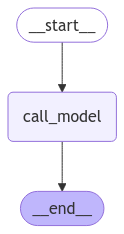

In [63]:
import getpass
import os
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore


in_memory_store = InMemoryStore()
memory = MemorySaver()

llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)


# 定义状态模式
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 定义对话节点， 访问记忆并在模型调用中使用它们。
def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # 获取用户id
    user_id = config["configurable"]["user_id"]

    # 定义命名空间
    namespace = ("memories", user_id)

    # 根据用户id检索记忆
    memories = store.search(namespace)
    info = "\n".join([d.value["data"] for d in memories])

    # # 存储记忆
    last_message = state["messages"][-1]
    store.put(namespace, str(uuid.uuid4()), {"data": last_message.content})

    system_msg = f"Answer the user's question in context: {info}"

    response = llm.invoke(
        [{"type": "system", "content": system_msg}] + state["messages"]
    )

    # 存储记忆
    store.put(namespace, str(uuid.uuid4()), {"data": response.content})
    return {"messages": response}

# 构建状态图
builder = StateGraph(State)

# 向图中添加节点
builder.add_node("call_model", call_model)

# 构建边
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# 编译图
graph = builder.compile(checkpointer=memory, store=in_memory_store)

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;接下来我们进行测试：

In [68]:
config = {"configurable": {"thread_id": "111"}, "user_id": "8"}

async for chunk in graph.astream({"messages": ["你好，我是西瓜老师"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你好，我是西瓜老师
================================== Ai Message ==================================

你好，西瓜老师！有什么我可以帮助你的吗？


In [69]:
config = {"configurable": {"thread_id": "111"}, "user_id": "8"}

async for chunk in graph.astream({"messages": ["你知道我叫什么吗？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你知道我叫什么吗？
================================== Ai Message ==================================

你自我介绍是西瓜老师，不过我并不知道你的真实姓名。如果你想分享更多信息或有其他问题需要帮助，请告诉我！


&emsp;&emsp;这一次我们传入相同的`user_id`，但开启一个新的线程：

In [70]:
config = {"configurable": {"thread_id": "22"}, "user_id": "8"}

async for chunk in graph.astream({"messages": ["你知道我叫什么吗？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你知道我叫什么吗？
================================== Ai Message ==================================

你自我介绍是西瓜老师，不过我并不知道你的真实姓名。如果你想分享更多信息或有其他问题需要帮助，请告诉我！


&emsp;&emsp;能够发现，我们已经正确的实现了跨线程的记忆能力。而如果使用新的`user_id`，将会开启全新的交互。

In [71]:
config = {"configurable": {"thread_id": "22"}, "user_id": "9"}

async for chunk in graph.astream({"messages": ["你知道我叫什么吗？"]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

你知道我叫什么吗？
================================== Ai Message ==================================

对不起，我无法知道你的名字。你可以告诉我，你想怎么称呼会对你更好。


&emsp;&emsp;我们可以直接去访问`store`查看存储的`memory`信息。

In [72]:
for memory in in_memory_store.search(("memories", "8")):
    print(memory.value)

{'data': '你好，我是西瓜老师'}
{'data': '你好，西瓜老师！有什么我可以帮助你的吗？'}
{'data': '你知道我叫什么吗？'}
{'data': '你自我介绍是西瓜老师，不过我并不知道你的真实姓名。如果你想分享更多信息或有其他问题需要帮助，请告诉我！'}
{'data': '你知道我叫什么吗？'}
{'data': '你自我介绍是西瓜老师，不过我并不知道你的真实姓名。如果你想分享更多信息或有其他问题需要帮助，请告诉我！'}


In [73]:
for memory in in_memory_store.search(("memories", "9")):
    print(memory.value)

{'data': '你知道我叫什么吗？'}
{'data': '对不起，我无法知道你的名字。你可以告诉我，你想怎么称呼会对你更好。'}


&emsp;&emsp;有效的记忆管理可以增强代理维护上下文、从过去的经验中学习以及随着时间的推移做出更明智决策的能力。大多数`AI Agent`构建的应用程序都需要记忆来在多个交互中共享上下文。在 `LangGraph` 中，这种记忆就是通过`checkpointer` 和 `store` 来做持久性，从而添加到任何`StateGraph`中。最常见的用例之一是用它来跟踪对话历史记录，但是也有很大的优化空间，因为随着对话变得越来越长，历史记录会累积并占用越来越多的上下文窗口，导致对大模型的调用更加昂贵和耗时，并且可能会出错。为了防止这种情况发生，我们一般是需要借助一些优化手段去管理对话历史记录，同时更加适配生产环境的` PostgresSaver / AsyncPostgresSaver ）`高级检查点，我们也将随着知识点的进一步补充后，再结合实际的案例进行详细的讲解。